In [1]:
import pandas as pd
import random
import numpy as np

from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import v_measure_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score

from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

In [2]:
from keras import backend as K
from keras import models
from keras import layers
from keras import optimizers
from keras import Sequential
from keras import losses
from keras import metrics
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
#построение диаграммы
def barplot(x_data, y_data, error_data, x_label="", y_label="", title="", cnt_l = 40, cnt_r = 15):
    fig, ax = plt.subplots(figsize = (cnt_l, cnt_r))
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center', width = 0.9)
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
    ax.errorbar(x_data, y_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_title(title)

    fig.savefig(title + '.png')
    
    plt.show()

#подсчет ошибок
def count_errors(y_pred, y_true, n):
    res = [0 for i in range(0,n)]
    
    cnt = 0
    
    for i in y_pred:
        i_true = y_true.iloc[cnt]
        if i != i_true:
            c = res.pop(i_true)
            res.insert(i_true, c + 1)
        cnt = cnt + 1
    return res

#построение матрицы ошибок
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, savef = False, cmap=plt.cm.Blues):
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize = (20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if savef:
        fig.savefig(title + '.png')
    plt.show()
    return ax

In [4]:
#обучение и проверка классификатора
def learn_test_classifier(x_train, y_train, x_test, y_test, classifier):
    classifier.fit(x_train, y_train)
    res = classifier.predict(x_test)

    print('hamming_loss: ', hamming_loss(y_test, res))
    print('matthews_corrcoef: ', matthews_corrcoef(y_test, res))
    print('accuracy_score: ', accuracy_score(y_test, res))
    print('precision_score: ', precision_score(y_test, res, average='macro'))
    print('recall_score: ', recall_score(y_test, res, average='macro'))
    print('f1_score: ', f1_score(y_test, res, average='macro'))
    
    return res

#прогон кластера
def start_clustering(data, y_test, cluster):
    cluster.fit(data)
    res = cluster.labels_

    print('accuracy_score: ', accuracy_score(y_test, res))
    print('hamming_loss: ', hamming_loss(y_test, res))
    print('matthews_corrcoef: ', matthews_corrcoef(y_test, res))
    print('precision_score: ', precision_score(y_test, res, average='macro'))
    print('recall_score: ', recall_score(y_test, res, average='macro'))
    print('f1_score: ', f1_score(y_test, res, average='macro'))
    print('completeness_score: ', completeness_score(y_test, res))
    print('adjusted_rand_score: ', adjusted_rand_score(y_test, res))
    print('v_measure_score: ', v_measure_score(y_test, res))
    
    return res

Предобработка данных

In [5]:
data = pd.read_csv('Data/Gaia/GaiaSource/GaiaSource0.csv' )
s = 'Data/Gaia/GaiaSource/GaiaSource'
for i in range(20,47):#47):
    s1 = s + str(i) + '.csv'
    data = data.append(pd.read_csv(s1), ignore_index=True)

In [6]:
data = data.drop(columns=['astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object_type', 'matched_observations',
       'duplicated_source', 'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'phot_g_n_obs',
       'phot_g_mean_flux', 'phot_g_mean_flux_error',
       'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_n_obs',
       'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
       'phot_bp_mean_flux_over_error', 'phot_bp_mean_mag', 'phot_rp_n_obs',
       'phot_rp_mean_flux', 'phot_rp_mean_flux_error',
       'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag',
       'phot_bp_rp_excess_factor', 'bp_rp', 'bp_g', 'g_rp']) 

data = data.drop(columns=['rv_template_teff', 'rv_template_logg', 'rv_template_fe_h',
       'phot_variable_flag', 'l', 'b', 'ecl_lon', 'ecl_lat', 'priam_flags',
       'teff_val', 'teff_percentile_lower', 'teff_percentile_upper', 'a_g_val',
       'a_g_percentile_lower', 'a_g_percentile_upper', 'e_bp_min_rp_val',
       'e_bp_min_rp_percentile_lower', 'e_bp_min_rp_percentile_upper',
       'flame_flags'])
data.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,phot_proc_mode,radial_velocity,radial_velocity_error,rv_nb_transits,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper
0,1635721458409799680,Gaia DR2 1000225938242805248,1000225938242805248,1197051105,2015.5,103.447529,0.041099,56.022025,0.045175,0.582790,...,0,NaN,NaN,0,1.024730,1.017359,1.038814,1.075774,0.801798,1.349751
1,1635721458409799680,Gaia DR2 1000383512003001728,1000383512003001728,598525552,2015.5,105.187856,0.016978,56.267982,0.016904,1.385686,...,0,NaN,NaN,0,1.388711,1.311143,1.453106,1.937890,1.852440,2.023341
2,1635721458409799680,Gaia DR2 1000274106300491264,1000274106300491264,299262776,2015.5,103.424758,0.464608,56.450903,0.582490,0.314035,...,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
3,1635721458409799680,Gaia DR2 1000396156385741312,1000396156385741312,1148557518,2015.5,105.049751,0.838232,56.508777,0.744511,1.939951,...,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
4,1635721458409799680,Gaia DR2 1000250024419296000,1000250024419296000,574278759,2015.5,103.352525,0.023159,56.395144,0.022836,0.747108,...,0,NaN,NaN,0,1.507958,1.435618,1.540208,2.427377,2.152597,2.702158


In [7]:
data = data.drop(columns = ['radial_velocity', 'radial_velocity_error', 'rv_nb_transits','phot_proc_mode', ])

In [8]:
data1 = pd.read_csv('Data/Gaia/light_curve/light_curves0.csv')

s = 'Data/Gaia/light_curve/light_curves'
for i in range(15,19):
    s1 = s + str(i) + '.csv'
    data1 = data1.append(pd.read_csv(s1))

In [9]:
data = data.dropna()
data_m = data.merge(data1, on='source_id')

In [10]:
data_m = data_m.drop(columns = ['solution_id_x', 'solution_id_y', 'rejected_by_photometry','rejected_by_variability', 'other_flags', 'random_index'])

In [11]:
data_m = data_m.drop(columns = ['radius_percentile_lower','radius_percentile_upper','lum_percentile_lower','lum_percentile_upper'])
data_m = data_m.drop(columns = ['designation'])# 'random_index', 'ref_epoch'
data_m.head()

,source_id,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,...,pmra_pmdec_corr,radius_val,lum_val,transit_id,band,time,mag,flux,flux_error,flux_over_error
0,1762304559921296768,2015.5,311.392496,0.032176,14.861018,0.032321,1.146271,0.039372,29.11372,10.371885,...,0.021288,0.812044,0.373563,20229154356912906,G,1762.678844,15.579629,11053.368985,15.153247,729.43896
1,1762304559921296768,2015.5,311.392496,0.032176,14.861018,0.032321,1.146271,0.039372,29.11372,10.371885,...,0.021288,0.812044,0.373563,21845830561607793,G,1791.913111,15.568158,11170.774175,15.306830,729.79016
2,1762304559921296768,2015.5,311.392496,0.032176,14.861018,0.032321,1.146271,0.039372,29.11372,10.371885,...,0.021288,0.812044,0.373563,23127363079786977,G,1815.087231,15.579278,11056.943748,18.126910,609.97400
3,1762304559921296768,2015.5,311.392496,0.032176,14.861018,0.032321,1.146271,0.039372,29.11372,10.371885,...,0.021288,0.812044,0.373563,23131455361570703,G,1815.161233,15.565434,11198.833624,106.208811,105.44167
4,1762304559921296768,2015.5,311.392496,0.032176,14.861018,0.032321,1.146271,0.039372,29.11372,10.371885,...,0.021288,0.812044,0.373563,29804144275367582,G,1935.835025,15.584589,11002.988241,17.473031,629.71260


In [12]:
for i in data_m.columns:
    if not i in ['phot_rp_n_obs', 'source_id','flux', 'flux_over_error', 'flux_error', 'time', 'mag', 'rejected_by_photometry','rejected_by_variability', 'band', 'random_index', 'ref_epoch', 'other_flags'] :
        data_m[i] = data_m[i].apply(lambda x: x+random.uniform(-0.85, 1.255))

In [13]:
z1 = []

for i in data_m['band'].drop_duplicates():
    z1.append(i)

def f1(x, z1):
    return int(z1.index(x))

data_m['band'] = data_m['band'].apply(lambda x: f1(x, z1))

In [14]:
z = []

for i in data_m['source_id'].drop_duplicates():
    z.append(i)

def f(x, z):
    return int(z.index(x))

y = data_m['source_id']
y = y.apply(lambda x: f(x, z))

In [15]:
n = len(data_m['source_id'].drop_duplicates())
data_m = data_m.drop(columns = ['source_id'])

In [16]:
m = len(data_m.columns)
p = len(y.drop_duplicates())

In [17]:
#Создаем основу для нашей модели. Для кросс-идентификации хорошо работает обычный многослойный персептрон
def base_model(input_shape = (m,)):
    input = Input(shape=input_shape)

    x = Dense(m*p*5, activation='relu', use_bias=True)(input)
    x = Dropout(0.5)(x)
    x = Dense(150, activation='relu', use_bias=True)(x)
    x = Dropout(0.1)(x)
    x = Dense(p, activation='softmax')(x)
    return Model(input, x)

#обучение модели жестким классам
def train_cross_entropy(model, train_x, train_y, test_x, test_y, n_epoch = 50, b_size = 1000, b = True):
    adam = optimizers.Adam()

    model.compile(loss=losses.CategoricalCrossentropy(label_smoothing = 0),
                  optimizer=adam,
                  metrics=['accuracy'])
    
    history = model.fit( train_x, train_y, epochs= n_epoch, batch_size = b_size, 
                        validation_data = (test_x, test_y), verbose = b)
    return history

In [18]:
data_m.head()

,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,...,pmra_pmdec_corr,radius_val,lum_val,transit_id,band,time,mag,flux,flux_error,flux_over_error
0,2015.5,311.712459,-0.714777,14.866872,0.199867,1.826824,0.801499,29.024430,9.646957,0.020883,...,0.925097,1.578744,0.021420,2.022915e+16,0,1762.678844,15.579629,11053.368985,15.153247,729.43896
1,2015.5,312.215818,0.131813,14.743969,0.851927,0.598294,1.282611,29.029580,9.981984,0.134527,...,-0.615105,0.428216,-0.438095,2.184583e+16,0,1791.913111,15.568158,11170.774175,15.306830,729.79016
2,2015.5,311.616648,-0.106574,16.101623,0.347254,2.024361,0.632203,30.070525,10.787091,0.925074,...,1.223273,0.355583,0.662056,2.312736e+16,0,1815.087231,15.579278,11056.943748,18.126910,609.97400
3,2015.5,310.926410,0.896153,15.201328,0.414622,2.166291,-0.753996,29.446431,10.877353,1.261665,...,-0.312271,0.819973,0.214302,2.313146e+16,0,1815.161233,15.565434,11198.833624,106.208811,105.44167
4,2015.5,310.728158,0.481618,14.479558,0.275108,0.759885,0.522137,30.087617,10.399288,0.254495,...,-0.390691,0.225089,-0.317484,2.980414e+16,0,1935.835025,15.584589,11002.988241,17.473031,629.71260


In [19]:
data_m.columns
#data_m = data_m.drop(columns = ['transit_id', 'band']) влияет на нейронку с помощью keras, но не влияет на svc 


Index(['ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec',
       'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr',
       'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'radius_val', 'lum_val', 'transit_id', 'band', 'time', 'mag', 'flux',
       'flux_error', 'flux_over_error'],
      dtype='object')

In [20]:
print(len(data_m))


10829


In [21]:
#делим данные на обучающую и тестовую выборки
#в данном примере test_size = 0.7, эксперименты проводились и для test_size = 0.3, как описано в статье
#на них же и подбиралась часть параметров
X_train, X_test, y_train, y_test = train_test_split(data_m, y, test_size=0.7, random_state = 42, shuffle = True)

In [22]:
#преобразуем данные в формат, подходящий для обучения модели

new_y = []

for i in y:
    el = [0.0 for i in range(p)]
    el[i] = 1.0
    new_y.append(el)
    
cat_y = to_categorical(y.values)

cat_train_y = to_categorical(y_train.values)
cat_test_y = to_categorical(y_test.values)

In [23]:
# набор данных с нормализованными значениями признаков 
data = data_m.copy()
for i in data.columns:
    if not i in ['source_id', 'band', 'rejected_by_photometry','rejected_by_variability','other_flags']:
        data[i] /= max(abs(data[i]))

Запуск моделей классификации

In [24]:
print('knn: ')
knn = KNeighborsClassifier(n_neighbors=2, leaf_size = 50)
knn_res = learn_test_classifier(X_train, y_train, X_test, y_test, knn)
print()

print('dt:')
dt = DecisionTreeClassifier()
dt_res = learn_test_classifier(X_train, y_train, X_test, y_test, dt)
print()

print('rf:')
rf = RandomForestClassifier(criterion = 'entropy')
rf_res = learn_test_classifier(X_train, y_train, X_test, y_test, rf)
print()

print('svc: ')
svc = SVC(kernel= 'sigmoid', verbose = True, random_state = 24, probability = True)
svc_res = learn_test_classifier(X_train, y_train, X_test, y_test, svc)
print()

print('xgb: ')
xgbM = xgb.XGBClassifier()
xgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, xgbM)
print()

print('lgb: ')
lgbM = lgb.LGBMClassifier(n_estimators=200, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27, objective = 'multiclass')
lgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, lgbM)
print()

print('mlp: ')
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*30,), verbose = False, max_iter= 50, tol = 0.0001)
mlp_res = learn_test_classifier(X_train, y_train, X_test, y_test, mlp)
print() #F1 - 0.00

model1 = base_model((len(data_m.columns), ))
history1 = train_cross_entropy(model1, X_train.values, cat_train_y, X_test.values, cat_test_y, 30, 2000)
print('-------------------------------')

knn: 
hamming_loss:  0.7108560875873895
matthews_corrcoef:  0.28221719242057086
accuracy_score:  0.28914391241261045
precision_score:  0.32768658455102867
recall_score:  0.2938596311978353
f1_score:  0.2807256007288906

dt:
hamming_loss:  0.015565228861627754
matthews_corrcoef:  0.9842793733205988
accuracy_score:  0.9844347711383723
precision_score:  0.9838398223944624
recall_score:  0.983653005988332
f1_score:  0.9833450378667933

rf:
hamming_loss:  0.0018467220683287165
matthews_corrcoef:  0.9981343533852229
accuracy_score:  0.9981532779316713
precision_score:  0.9980245149400225
recall_score:  0.9980744613069192
f1_score:  0.9980327457824155

svc: 
[LibSVM]hamming_loss:  0.9939321989183485
matthews_corrcoef:  -0.01408319959691313
accuracy_score:  0.0060678010816514975
precision_score:  9.22411607314535e-05
recall_score:  0.004087707457210598
f1_score:  0.00017928229232804172

xgb: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hamming_loss:  0.023875478169106977
matthews_corrcoef:  0.975884754647803
accuracy_score:  0.976124521830893
precision_score:  0.977577823325361
recall_score:  0.9734411539995425
f1_score:  0.9748573005488691

lgb: 
hamming_loss:  0.01701622477245746
matthews_corrcoef:  0.982813067155447
accuracy_score:  0.9829837752275425
precision_score:  0.9833009812984221
recall_score:  0.9807455515671545
f1_score:  0.9815973872856415

mlp: 
hamming_loss:  0.9907663896583564
matthews_corrcoef:  0.0
accuracy_score:  0.009233610341643583
precision_score:  8.96467023460542e-05
recall_score:  0.009708737864077669
f1_score:  0.00017765302587516323



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 3248 samples, validate on 7581 samples
Epoch 1/30
3248/3248 [==============================] - 2s 562us/step - loss: 1930839394319576.7500 - accuracy: 0.0071 - val_loss: 2371347726831397.0000 - val_accuracy: 0.0107
Epoch 2/30
3248/3248 [==============================] - 2s 535us/step - loss: 2532516277749487.5000 - accuracy: 0.0089 - val_loss: 1036465943978199.0000 - val_accuracy: 0.0066
Epoch 3/30
3248/3248 [==============================] - 2s 536us/step - loss: 976360954772454.7500 - accuracy: 0.0083 - val_loss: 40247657669713.4531 - val_accuracy: 0.0099
Epoch 4/30
3248/3248 [==============================] - 2s 530us/step - loss: 41562990229372.8438 - accuracy: 0.0108 - val_loss: 4.6348 - val_accuracy: 0.0091
Epoch 5/30
3248/3248 [==============================] - 2s 532us/step - loss: 4.6346 - accuracy: 0.0142 - val_loss: 4.6348 - val_accuracy: 0.0145
Epoch 6/30
3248/3248 [==============================] - 2s 532us/step - loss: 4.6345 - accuracy: 0.0172 - val_loss: 4.6347

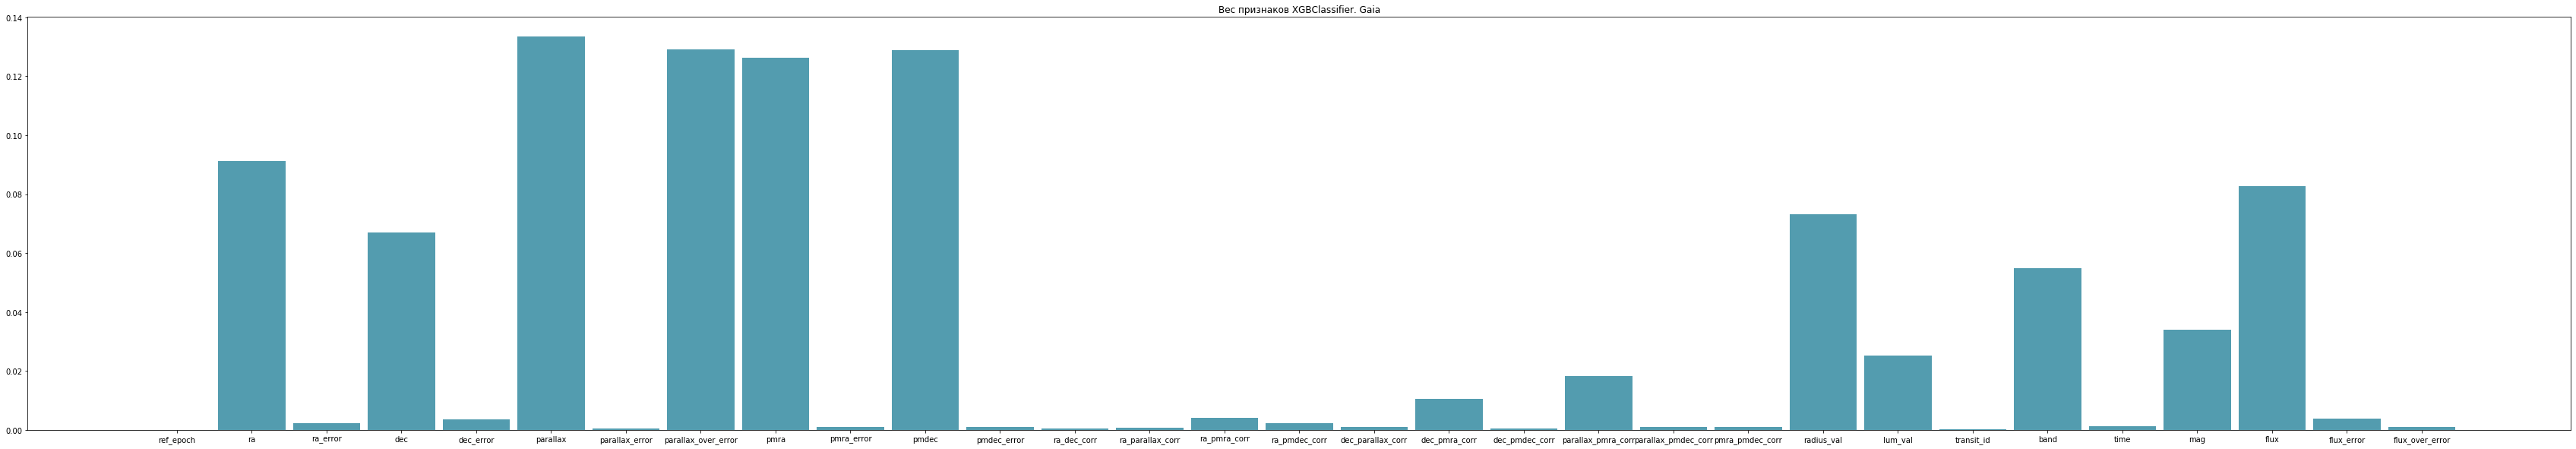

In [25]:
weight_f = xgbM.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков XGBClassifier. Gaia', 60, 10)

Проверим, что будет при другом наборе данных

In [26]:
data_1 = data_m.drop(columns = ['time', 'transit_id', 'radius_val', 'parallax_over_error', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',])
X_train, X_test, y_train, y_test = train_test_split(data_1, y, test_size=0.7, shuffle = True, random_state = 42)

knn: 
hamming_loss:  0.9270544783010157
matthews_corrcoef:  0.06400369717950263
accuracy_score:  0.0729455216989843
precision_score:  0.10816725569790962
recall_score:  0.06878114786077111
f1_score:  0.07265245207117343

dt:
hamming_loss:  0.014114232950798047
matthews_corrcoef:  0.9857496013861513
accuracy_score:  0.9858857670492019
precision_score:  0.9861675852485846
recall_score:  0.985518443443374
f1_score:  0.9852439990817813

rf:
hamming_loss:  0.0017148133491623797
matthews_corrcoef:  0.9982675124799155
accuracy_score:  0.9982851866508377
precision_score:  0.9980716202458579
recall_score:  0.9980578309018917
f1_score:  0.9980527227404222

svc: 
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=80).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


hamming_loss:  0.8062260915446511
matthews_corrcoef:  0.18649484292314897
accuracy_score:  0.1937739084553489
precision_score:  0.21834331406871824
recall_score:  0.17020715093321004
f1_score:  0.16128554912528997

xgb: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hamming_loss:  0.023875478169106977
matthews_corrcoef:  0.975884754647803
accuracy_score:  0.976124521830893
precision_score:  0.977577823325361
recall_score:  0.9734411539995425
f1_score:  0.9748573005488691

lgb: 
hamming_loss:  0.01701622477245746
matthews_corrcoef:  0.982813067155447
accuracy_score:  0.9829837752275425
precision_score:  0.9833009812984221
recall_score:  0.9807455515671545
f1_score:  0.9815973872856415

mlp: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


hamming_loss:  0.18915710328452712
matthews_corrcoef:  0.8091612545704342
accuracy_score:  0.8108428967154729
precision_score:  0.8263857554569485
recall_score:  0.8085123923291623
f1_score:  0.8061263688573475

Train on 3248 samples, validate on 7581 samples
Epoch 1/30
3248/3248 [==============================] - 2s 532us/step - loss: 4.6287 - accuracy: 0.0157 - val_loss: 4.5980 - val_accuracy: 0.0141
Epoch 2/30
3248/3248 [==============================] - 2s 538us/step - loss: 4.5683 - accuracy: 0.0249 - val_loss: 4.5450 - val_accuracy: 0.0368
Epoch 3/30
3248/3248 [==============================] - 2s 607us/step - loss: 4.4940 - accuracy: 0.0551 - val_loss: 4.4708 - val_accuracy: 0.0737
Epoch 4/30
3248/3248 [==============================] - 2s 614us/step - loss: 4.3988 - accuracy: 0.0902 - val_loss: 4.3837 - val_accuracy: 0.0817
Epoch 5/30
3248/3248 [==============================] - 2s 557us/step - loss: 4.2913 - accuracy: 0.1013 - val_loss: 4.2848 - val_accuracy: 0.0886
Epoch 6/30

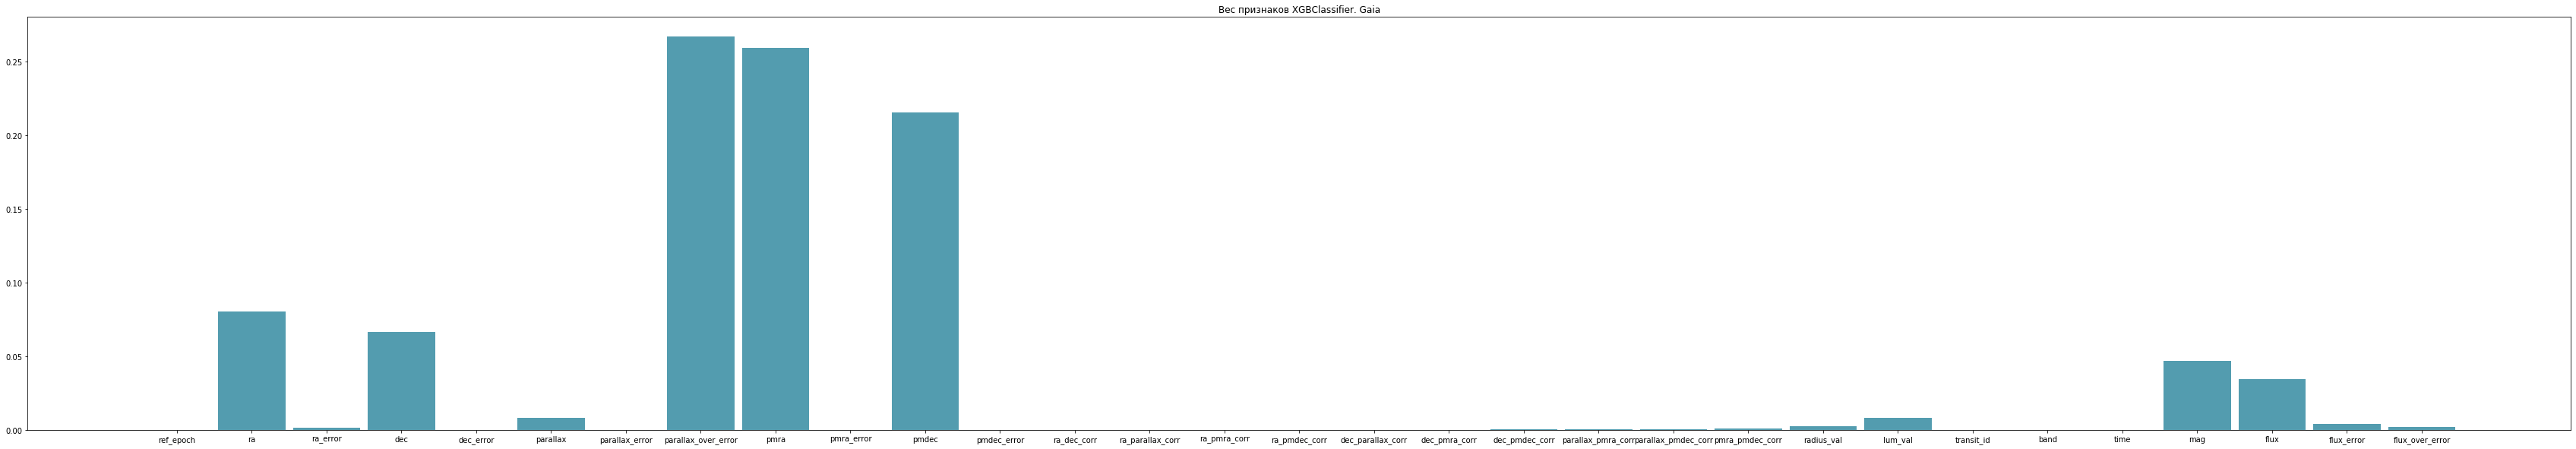

In [36]:
print('knn: ')
knn = KNeighborsClassifier(n_neighbors=5, leaf_size = 30)
knn_res = learn_test_classifier(X_train, y_train, X_test, y_test, knn)
print()

print('dt:')
dt = DecisionTreeClassifier()
dt_res = learn_test_classifier(X_train, y_train, X_test, y_test, dt)
print()

print('rf:')
rf = RandomForestClassifier(criterion = 'entropy')
rf_res = learn_test_classifier(X_train, y_train, X_test, y_test, rf)
print()

print('svc: ')
svc = SVC(kernel='rbf', max_iter = 80, verbose = True, random_state = 24, probability = True)
svc_res = learn_test_classifier(X_train, y_train, X_test, y_test, svc)
print()

print('xgb: ')
xgbM = xgb.XGBClassifier()
xgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, xgbM)
print()

print('lgb: ')
lgbM = lgb.LGBMClassifier(n_estimators=200, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27, objective = 'multiclass')
lgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, lgbM)
print()

print('mlp: ')
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*30,), verbose = False, max_iter= 50, tol = 0.0001)
mlp_res = learn_test_classifier(X_train, y_train, X_test, y_test, mlp)
print()

model1 = base_model((len(X_train.columns), ))
history1 = train_cross_entropy(model1, X_train.values, cat_train_y, X_test.values, cat_test_y, 30, 2000)
print('-------------------------------')

weight_f = dt.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков XGBClassifier. Gaia', 60, 10)

knn: 
hamming_loss:  0.47183748845798706
matthews_corrcoef:  0.5233843953232924
accuracy_score:  0.5281625115420129
precision_score:  0.5093745332909909
recall_score:  0.5100302788938773
f1_score:  0.499584388769334

dt:
hamming_loss:  0.27265532251681834
matthews_corrcoef:  0.724616770723838
accuracy_score:  0.7273446774831817
precision_score:  0.7247859096300739
recall_score:  0.7189170971481345
f1_score:  0.7173622444518505

rf:
hamming_loss:  0.15868618915710328
matthews_corrcoef:  0.8398713509773422
accuracy_score:  0.8413138108428967
precision_score:  0.8517097790253251
recall_score:  0.8398525973243671
f1_score:  0.8361782270527918

svc: 
[LibSVM]hamming_loss:  0.9725629864134019
matthews_corrcoef:  0.08145930274749483
accuracy_score:  0.027437013586598075
precision_score:  0.009851456180935686
recall_score:  0.019319407668922234
f1_score:  0.009940756436104125

xgb: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hamming_loss:  0.20788814140614695
matthews_corrcoef:  0.7900392280836778
accuracy_score:  0.792111858593853
precision_score:  0.7948744181252043
recall_score:  0.7875615073616139
f1_score:  0.7863573218371607

lgb: 
hamming_loss:  0.1565756496504419
matthews_corrcoef:  0.8418876222317097
accuracy_score:  0.8434243503495581
precision_score:  0.8473529063289961
recall_score:  0.8397229279922332
f1_score:  0.8390483362996516

mlp: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


hamming_loss:  0.9199314074660335
matthews_corrcoef:  0.07804336320666964
accuracy_score:  0.08006859253396649
precision_score:  0.03675980268896264
recall_score:  0.07773086981198025
f1_score:  0.03921817638115029



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train on 3248 samples, validate on 7581 samples
Epoch 1/30
3248/3248 [==============================] - 2s 565us/step - loss: 17243.6376 - accuracy: 0.0108 - val_loss: 16996.2018 - val_accuracy: 0.0131
Epoch 2/30
3248/3248 [==============================] - 2s 631us/step - loss: 17690.0976 - accuracy: 0.0142 - val_loss: 22531.3661 - val_accuracy: 0.0131
Epoch 3/30
3248/3248 [==============================] - 2s 580us/step - loss: 21399.5527 - accuracy: 0.0148 - val_loss: 22493.3725 - val_accuracy: 0.0140
Epoch 4/30
3248/3248 [==============================] - 2s 536us/step - loss: 20960.8221 - accuracy: 0.0169 - val_loss: 18595.9944 - val_accuracy: 0.0207
Epoch 5/30
3248/3248 [==============================] - 2s 643us/step - loss: 16671.2647 - accuracy: 0.0219 - val_loss: 12490.1310 - val_accuracy: 0.0154
Epoch 6/30
3248/3248 [==============================] - 2s 609us/step - loss: 33442.3096 - accuracy: 0.0228 - val_loss: 13230.3094 - val_accuracy: 0.0186
Epoch 7/30
3248/3248 [======

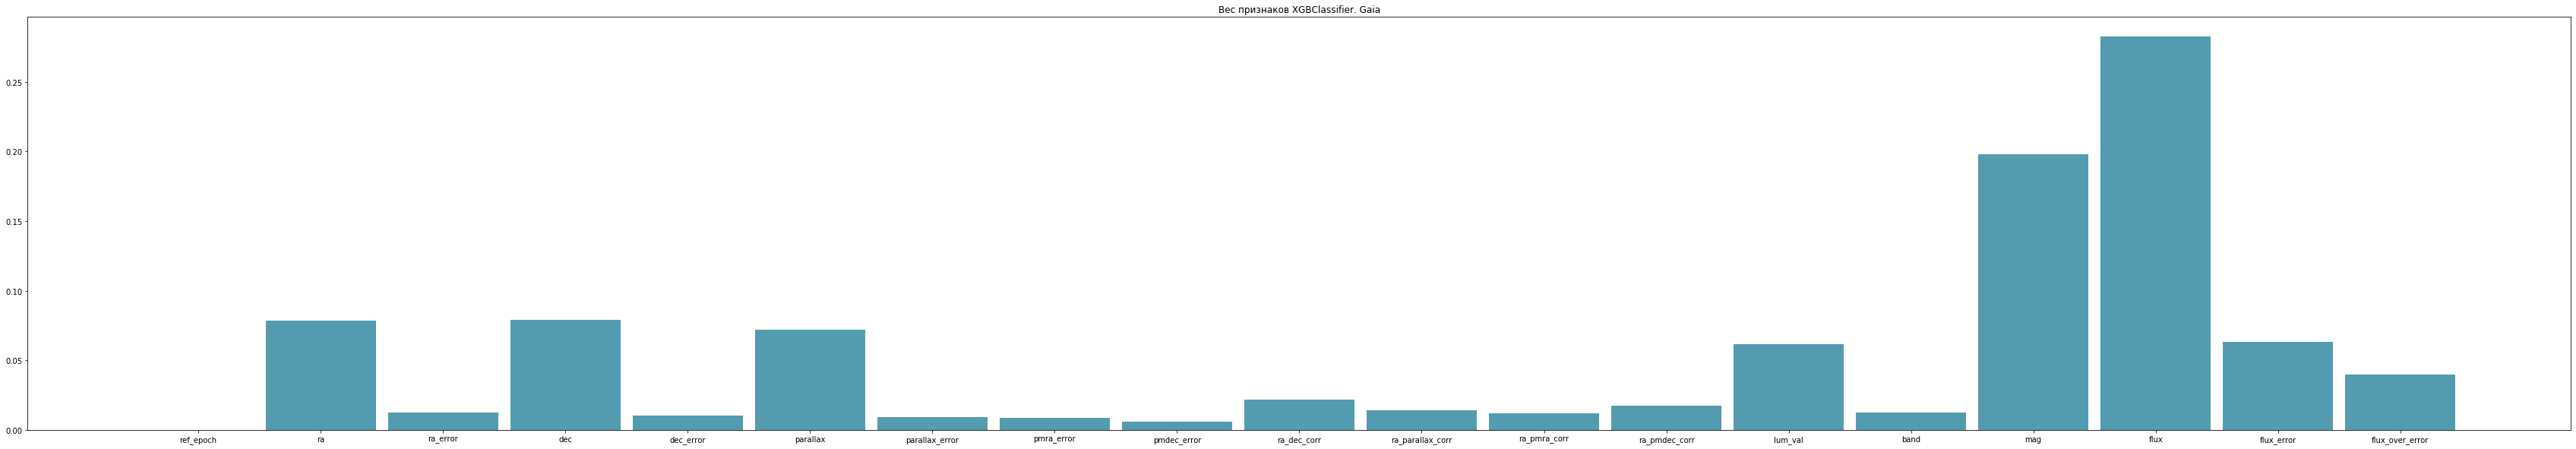

In [37]:
data_1 = data_m.drop(columns = ['time', 'transit_id', 'radius_val', 'parallax_over_error', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'pmra', 'pmdec'])
X_train, X_test, y_train, y_test = train_test_split(data_1, y, test_size=0.7, shuffle = True, random_state = 42)

print('knn: ')
knn = KNeighborsClassifier(n_neighbors=5, leaf_size = 30)
knn_res = learn_test_classifier(X_train, y_train, X_test, y_test, knn)
print()

print('dt:')
dt = DecisionTreeClassifier()
dt_res = learn_test_classifier(X_train, y_train, X_test, y_test, dt)
print()

print('rf:')
rf = RandomForestClassifier(criterion = 'entropy')
rf_res = learn_test_classifier(X_train, y_train, X_test, y_test, rf)
print()

print('svc: ')
svc = SVC(kernel='rbf', max_iter = 80, verbose = True, random_state = 24, probability = True)
svc_res = learn_test_classifier(X_train, y_train, X_test, y_test, svc)
print()

print('xgb: ')
xgbM = xgb.XGBClassifier()
xgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, xgbM)
print()

print('lgb: ')
lgbM = lgb.LGBMClassifier(n_estimators=200, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27, objective = 'multiclass')
lgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, lgbM)
print()

print('mlp: ')
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*30,), verbose = False, max_iter= 50, tol = 0.0001)
mlp_res = learn_test_classifier(X_train, y_train, X_test, y_test, mlp)
print()

model1 = base_model((len(X_train.columns), ))
history1 = train_cross_entropy(model1, X_train.values, cat_train_y, X_test.values, cat_test_y, 30, 2000)
print('-------------------------------')

weight_f = dt.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков XGBClassifier. Gaia', 60, 10)

Проверка при нормализации данных

In [29]:
#делим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.7, shuffle = True, random_state = 42)

In [30]:
new_y = []

for i in y:
    el = [0.0 for i in range(p)]
    el[i] = 1.0
    new_y.append(el)
    
cat_y = to_categorical(y.values)

cat_train_y = to_categorical(y_train.values)
cat_test_y = to_categorical(y_test.values)

In [31]:
print('knn: ')
knn = KNeighborsClassifier(n_neighbors=5, leaf_size = 30)
knn_res = learn_test_classifier(X_train, y_train, X_test, y_test, knn)
print()

print('dt:')
dt = DecisionTreeClassifier()
dt_res = learn_test_classifier(X_train, y_train, X_test, y_test, dt)
print()

print('rf:')
rf = RandomForestClassifier(criterion = 'entropy')
rf_res = learn_test_classifier(X_train, y_train, X_test, y_test, rf)
print()

print('svc: ')
svc = SVC(kernel='rbf', max_iter = 80, verbose = True, random_state = 24, probability = True)
svc_res = learn_test_classifier(X_train, y_train, X_test, y_test, svc)
print()

print('xgb: ')
xgbM = xgb.XGBClassifier()
xgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, xgbM)
print()

print('lgb: ')
lgbM = lgb.LGBMClassifier(n_estimators=200, silent=True,  num_leaves = 25, learning_rate = 0.03, random_state = 27, objective = 'multiclass')
lgb_res = learn_test_classifier(X_train, y_train, X_test, y_test, lgbM)
print()

print('mlp: ')
mlp = MLPClassifier(hidden_layer_sizes=((m+p)*30,), verbose = False, max_iter= 50, tol = 0.0001)
mlp_res = learn_test_classifier(X_train, y_train, X_test, y_test, mlp)
print()

model1 = base_model((len(X_train.columns), ))
history1 = train_cross_entropy(model1, X_train.values, cat_train_y, X_test.values, cat_test_y, 30, 2000)
print('-------------------------------')

knn: 
hamming_loss:  0.9270544783010157
matthews_corrcoef:  0.06400369717950263
accuracy_score:  0.0729455216989843
precision_score:  0.10816725569790962
recall_score:  0.06878114786077111
f1_score:  0.07265245207117343

dt:
hamming_loss:  0.01688431605329112
matthews_corrcoef:  0.9829463280160357
accuracy_score:  0.9831156839467089
precision_score:  0.982918045421201
recall_score:  0.9821887106847942
f1_score:  0.982181555377436

rf:
hamming_loss:  0.001187178472497032
matthews_corrcoef:  0.9988008546316078
accuracy_score:  0.998812821527503
precision_score:  0.998759289918379
recall_score:  0.9986069469428097
f1_score:  0.9986566587855344

svc: 
[LibSVM]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=80).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


hamming_loss:  0.8062260915446511
matthews_corrcoef:  0.18649484292314897
accuracy_score:  0.1937739084553489
precision_score:  0.21834331406871824
recall_score:  0.17020715093321004
f1_score:  0.16128554912528997

xgb: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


hamming_loss:  0.023875478169106977
matthews_corrcoef:  0.975884754647803
accuracy_score:  0.976124521830893
precision_score:  0.977577823325361
recall_score:  0.9734411539995425
f1_score:  0.9748573005488691

lgb: 
hamming_loss:  0.01701622477245746
matthews_corrcoef:  0.982813067155447
accuracy_score:  0.9829837752275425
precision_score:  0.9833009812984221
recall_score:  0.9807455515671545
f1_score:  0.9815973872856415

mlp: 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


hamming_loss:  0.19139955151035484
matthews_corrcoef:  0.8067976106680314
accuracy_score:  0.8086004484896452
precision_score:  0.8294874792916689
recall_score:  0.8083273916138999
f1_score:  0.8099969253089008

Train on 3248 samples, validate on 7581 samples
Epoch 1/30
3248/3248 [==============================] - 2s 542us/step - loss: 4.6256 - accuracy: 0.0185 - val_loss: 4.5914 - val_accuracy: 0.0148
Epoch 2/30
3248/3248 [==============================] - 2s 532us/step - loss: 4.5602 - accuracy: 0.0234 - val_loss: 4.5423 - val_accuracy: 0.0269
Epoch 3/30
3248/3248 [==============================] - 2s 618us/step - loss: 4.4868 - accuracy: 0.0499 - val_loss: 4.4741 - val_accuracy: 0.0561
Epoch 4/30
3248/3248 [==============================] - 2s 560us/step - loss: 4.3940 - accuracy: 0.0785 - val_loss: 4.3895 - val_accuracy: 0.0901
Epoch 5/30
3248/3248 [==============================] - 2s 538us/step - loss: 4.2924 - accuracy: 0.1044 - val_loss: 4.2980 - val_accuracy: 0.0962
Epoch 6/30

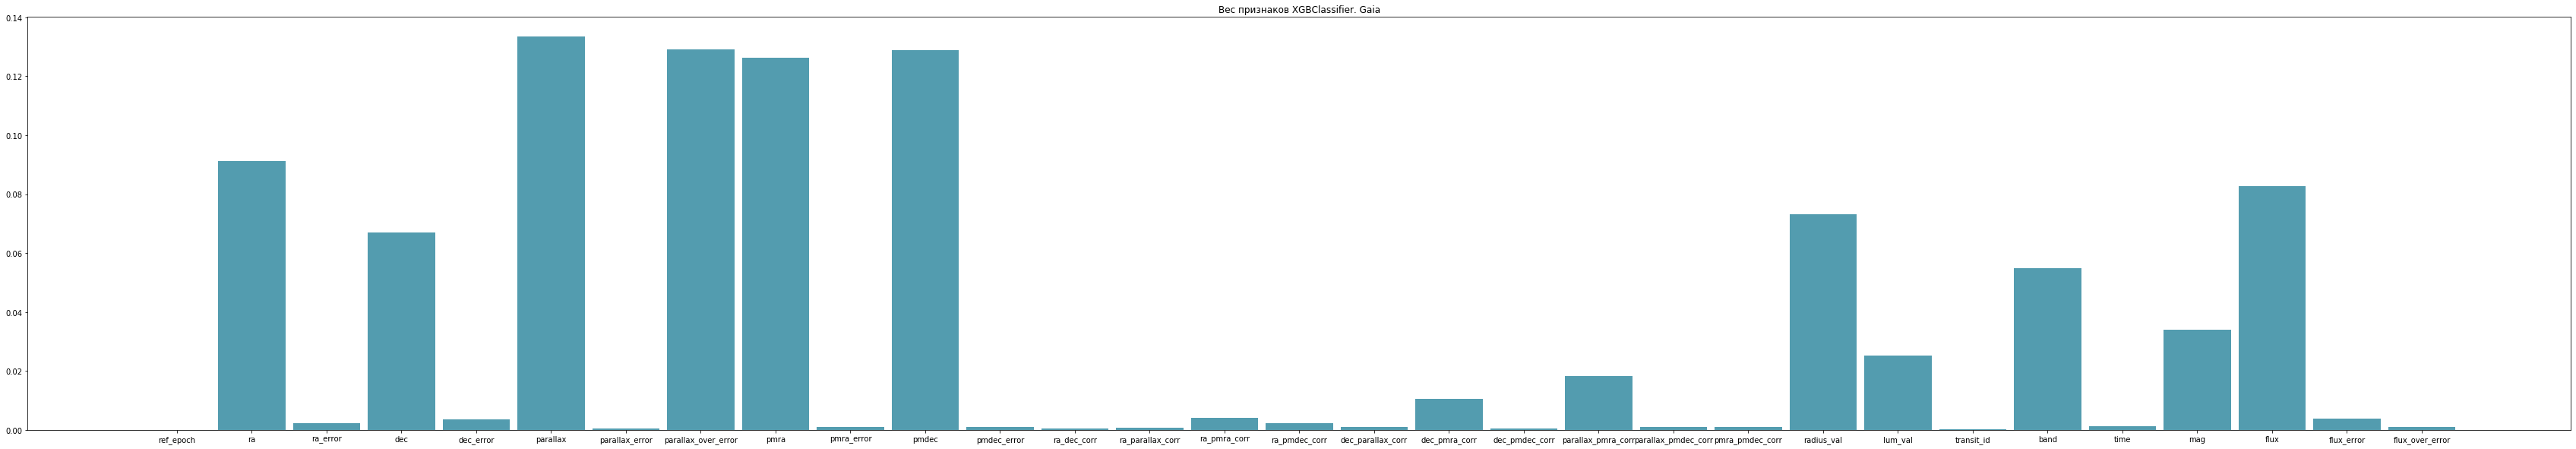

In [32]:
weight_f = xgbM.feature_importances_

col_lab = []
for i in X_train.columns:
    col_lab.append(i)

barplot(col_lab, weight_f, '', '', '', 'Вес признаков XGBClassifier. Gaia', 60, 10)

Кластеризация

In [33]:
cluster1 = SpectralClustering(n_clusters = n, random_state = 25, affinity = 'nearest_neighbors', n_neighbors=3)#'rbf')#
y_test1 = y
data1 = data_m
cluster1.fit(data1)
res = cluster1.labels_

print('completeness_score: ', completeness_score(y_test1, res))
print('adjusted_rand_score: ', adjusted_rand_score(y_test1, res))
print('v_measure_score: ', v_measure_score(y_test1, res))
print()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


completeness_score:  0.15141617204027338
adjusted_rand_score:  0.0006143447664283704
v_measure_score:  0.08496677642001647



In [34]:
cluster2 = AgglomerativeClustering(n_clusters = n, affinity = 'euclidean')
cluster2.fit(data1)
res = cluster2.labels_

print('completeness_score: ', completeness_score(y_test1, res))
print('adjusted_rand_score: ', adjusted_rand_score(y_test1, res))
print('v_measure_score: ', v_measure_score(y_test1, res))


completeness_score:  0.363472980478976
adjusted_rand_score:  0.038379241911259146
v_measure_score:  0.36096891696464983


In [35]:
cluster3 = KMeans(n_clusters= n, init = 'random', n_init=5, max_iter=500)
cluster3.fit(data1)
res = cluster3.labels_

print('completeness_score: ', completeness_score(y_test1, res))
print('adjusted_rand_score: ', adjusted_rand_score(y_test1, res))
print('v_measure_score: ', v_measure_score(y_test1, res))

completeness_score:  0.34939959409428367
adjusted_rand_score:  0.03486211835971412
v_measure_score:  0.3428317958636919


103
[95, 106, 98, 100, 98, 95, 74, 81, 98, 89, 93, 107, 95, 101, 92, 96, 86, 85, 94, 145, 104, 77, 92, 87, 147, 158, 150, 118, 137, 90, 123, 168, 104, 112, 130, 166, 110, 95, 114, 51, 84, 88, 82, 111, 92, 85, 106, 83, 100, 104, 83, 71, 76, 97, 88, 86, 62, 93, 97, 93, 118, 114, 78, 85, 81, 64, 89, 115, 88, 45, 101, 99, 115, 116, 114, 73, 75, 98, 69, 72, 72, 128, 148, 122, 161, 130, 142, 143, 145, 155, 143, 138, 150, 153, 111, 96, 121, 126, 110, 127, 112, 133, 112]


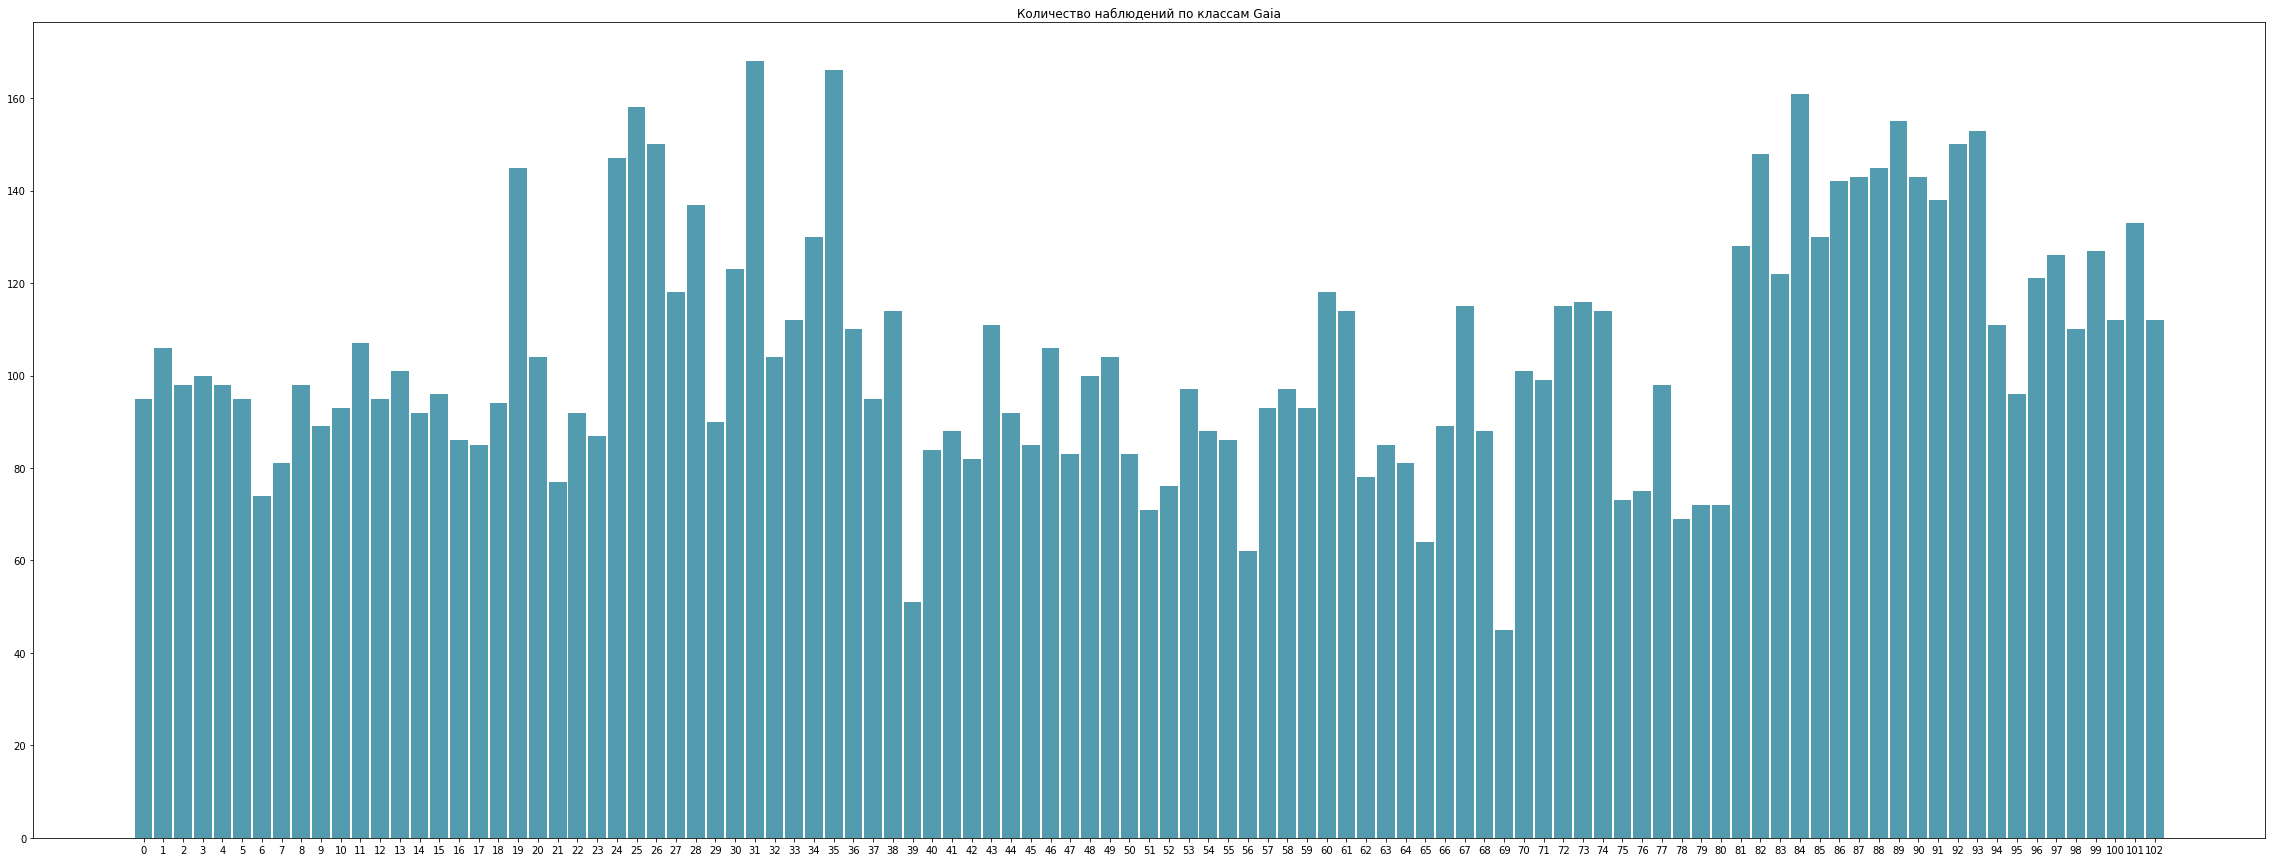

In [106]:

k = len(y.drop_duplicates())
print(k)

num_obs = []

for i in range(0, k):
    num_obs.append(len(y.where(lambda x: x == i).dropna()))
print(num_obs)
  
x_lab = []
for i in range(0,k):
    x_lab.append(str(i))

barplot(x_lab, num_obs, '', '', '', 'Количество наблюдений по классам Gaia')
